In [1]:
!pip install qwen_vl_utils

### Video Understanding with Qwen2.5-VL

In this notebook, we delve into the capabilities of the **Qwen2.5-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios, ranging from basic OCR to complex event detection and summarization.


#### \[Setup\]

We start by loading the pre-trained `Qwen2_5_VLForConditionalGeneration` model. This model has been fine-tuned on a diverse set of video understanding tasks, enabling it to generate detailed and accurate descriptions based on visual inputs.


In [2]:
!pip install flash-attn --no-build-isolation


In [3]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

model_path = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Load video frames and timestamps

In [5]:
!pip install qwen-vl-utils[decord]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 38.9 MB/s eta 0:00:00


In [6]:
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
    if video_path.startswith('http://') or video_path.startswith('https://'):
        video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)

    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image


Inference function

In [7]:
def inference(video_path, prompt, max_new_tokens=2048, total_pixels=20480 * 28 * 28, min_pixels=16 * 28 * 28):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"video": video_path, "total_pixels": total_pixels, "min_pixels": min_pixels},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True)
    fps_inputs = video_kwargs['fps']
    print("video input:", video_inputs[0].shape)
    num_frames, _, resized_height, resized_width = video_inputs[0].shape
    print("num of video tokens:", int(num_frames / 2 * resized_height / 28 * resized_width / 28))
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs, fps=fps_inputs, padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

Inference function with API using OpenAI SDK.

**Important Notice:**
- Please be aware that the current API supports video processing up to a maximum length of 10 minutes.
- Currently, the model inference interface does not support configuring the resolution of video frames. Therefore, it is recommended to resize videos with higher resolutions and longer durations to a smaller resolution to ensure that the input sequence is not excessively long. We advise keeping the number of video tokens under 24k to achieve better video grounding results.

In [8]:
import os
from openai import OpenAI
from IPython.display import Markdown, display


def inference_with_api(
    video_path,
    prompt,
    sys_prompt = "You are a helpful assistant.",
    model_id = "qwen-vl-max-latest",
):
    client = OpenAI(
        api_key = os.getenv('DASHSCOPE_API_KEY'),
        base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1",
    )
    messages = [
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]
        },
        {
            "role": "user",
            "content": [
                {"type": "video_url", "video_url": {"url": video_path}},
                {"type": "text", "text": prompt},
            ]
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
    )
    print(completion)
    return completion.choices[0].message.content

#### 1. Reading Text in Videos

In this section, we demonstrate how the model can be used to recognize and summarize text within a video. Specifically, we'll use a video containing various products and ask the model to summarize their characteristics in a structured format.


In [15]:
video_url = "https://duguang-labelling.oss-cn-shanghai.aliyuncs.com/qiansun/video_ocr/videos/50221078283.mp4"
# prompt = "请用表格总结一下视频中的商品特点"

## Use a local HuggingFace model to inference.
video_path, frames, timestamps = get_video_frames(video_url, num_frames=4)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

# response = inference(video_path, prompt)
# display(Markdown(response))

video_url = "/media/CAM2.avi"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with 'mm:ss.ff' format for time depiction."

# video_path, frames, timestamps = get_video_frames(video_url, num_frames=16)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))
# inference
response = inference(video_path, prompt,max_new_tokens=512,total_pixels=512 * 28 * 28, min_pixels=8 * 28 * 28  )
display(Markdown(response))

video input: torch.Size([58, 3, 84, 140])
num of video tokens: 435


```json
[
    {
        "start_time": "00:00.00",
        "end_time": "00:12.80",
        "description": "A person is shown putting fruits into a container."
    },
    {
        "start_time": "00:13.50",
        "end_time": "00:24.70",
        "description": "The container is then shown being sealed."
    },
    {
        "start_time": "00:25.40",
        "end_time": "00:29.60",
        "description": "The container is shown again, this time with the lid open."
    }
]
```

In [ ]:
## Use API for inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'

video_url = "http://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/cookbook/video_ocr.mp4"
prompt = "Watch the video and list the paper titles in a table, add one extra column for translating the paper titles to Chinese."

response = inference_with_api(video_url, prompt)
display(Markdown(response))

ChatCompletion(id='chatcmpl-7b270528-1209-998b-b208-4846197d55c2', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Here is a table listing the paper titles from the video, along with their translations to Chinese:\n\n| Paper Title (English) | Paper Title (Chinese) |\n|-----------------------|-----------------------|\n| Deep Unified Representation for Heterogeneous Recommendation | 异构推荐的深度统一表示 |\n| A New Sequential Prediction Framework with Spatial-temporal Embedding | 带有空间-时间嵌入的新序列预测框架 |\n| NeW CRFs: Neural Window Fully-connected CRFs for Monocular Depth Estimation | 单目深度估计的神经窗口全连接CRFs |\n| OFA: Unifying Architectures, Tasks, and Modalities Through a Simple Sequence-to-Sequence Learning Framework | 通过简单序列到序列学习框架统一架构、任务和模态 |\n| KoMen: Domain Knowledge-Guided Interaction Recommendation for Emerging Scenarios | 新兴场景中的领域知识引导交互推荐 |\n| Vision-Language Pre-Training for Boosting Scene Text Detectors | 提升场景文本检测器的视觉-语言预训练 |\n\nNote: The transl

Here is a table listing the paper titles from the video, along with their translations to Chinese:

| Paper Title (English) | Paper Title (Chinese) |
|-----------------------|-----------------------|
| Deep Unified Representation for Heterogeneous Recommendation | 异构推荐的深度统一表示 |
| A New Sequential Prediction Framework with Spatial-temporal Embedding | 带有空间-时间嵌入的新序列预测框架 |
| NeW CRFs: Neural Window Fully-connected CRFs for Monocular Depth Estimation | 单目深度估计的神经窗口全连接CRFs |
| OFA: Unifying Architectures, Tasks, and Modalities Through a Simple Sequence-to-Sequence Learning Framework | 通过简单序列到序列学习框架统一架构、任务和模态 |
| KoMen: Domain Knowledge-Guided Interaction Recommendation for Emerging Scenarios | 新兴场景中的领域知识引导交互推荐 |
| Vision-Language Pre-Training for Boosting Scene Text Detectors | 提升场景文本检测器的视觉-语言预训练 |

Note: The translations are approximate and may vary depending on context.

#### 2. Long Video Understanding

Next, we explore the model's capability to comprehend extremely long videos, such as those lasting up to one hour. This demonstrates how the model can effectively process and analyze extended video content, extracting meaningful insights over longer durations.

To reduce the number of visual tokens generated from a long video, you can specify the `resized_height` and `resized_width` parameters. These settings allow the video frames to be resized to a smaller dimension, effectively decreasing the computational load while maintaining the essential visual information needed for analysis.


In [ ]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/evaluations/data/LVBench/videos/GcRKREorGSc.mp4"
prompt = "Could you go into detail about the content of this long video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


video input: torch.Size([768, 3, 140, 252])
num of video tokens: 17280


The video begins with a serene view of a vast, open landscape under a bright blue sky dotted with fluffy white clouds. The scene transitions to a close-up of a lion's face, showcasing its intense gaze and powerful features. The camera then pans out to reveal a herd of antelope grazing peacefully in the distance, their graceful movements contrasting with the stillness of the lions.

Next, the video shifts to a close-up of a cheetah's face, highlighting its sharp eyes and sleek fur. The camera captures the cheetah's agile movements as it runs through the grassy field, emphasizing its speed and agility. The scene then transitions to a group of vultures perched on a tree branch, their keen eyes scanning the surroundings for any signs of movement or activity.

The video continues with a series of dynamic scenes featuring various animals in their natural habitats. A cheetah is seen running through the grassy field, its powerful strides and focused expression captured in detail. The camera then shifts to a group of antelope grazing peacefully, their graceful movements and interactions highlighted against the backdrop of the expansive landscape.

As the video progresses, the focus remains on the diverse wildlife and their natural behaviors. A cheetah is shown lying down, its relaxed posture and calm demeanor contrasted with the earlier scenes of movement. The camera then captures a group of antelope grazing, their synchronized movements and interactions adding to the sense of harmony in the ecosystem.

The video also includes moments of interaction between different species. A cheetah is seen observing a group of antelope from a distance, its keen eyes scanning the area for any potential threats or prey. This scene emphasizes the predator-prey dynamics within the ecosystem.

Throughout the video, the camera captures the beauty and diversity of the African savanna, showcasing the intricate relationships between different species and the serene yet dynamic nature of the landscape. The video concludes with a final shot of the vast, open landscape, leaving viewers with a sense of awe and appreciation for the natural world.

#### 3. Video Grounding

This part focuses on answering specific questions about a video segment. We specify a textual query and ask the model what is the period that the described content occur in the video, showcasing the model's ability to understand timestamps and search the detailed queries.

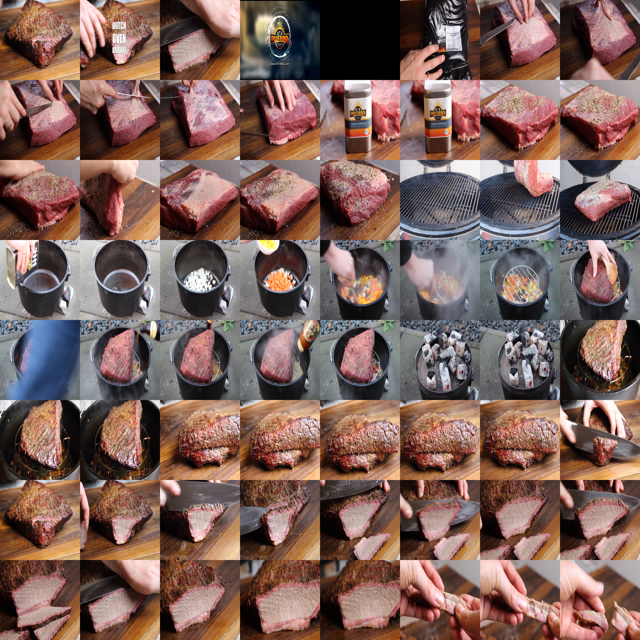

video input: torch.Size([530, 3, 168, 308])
num of video tokens: 17490


The given query happens in 64.0 - 72.0 seconds.

In [ ]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Give the query: 'seasoning the steak', when does the described content occur in the video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
image_grid = create_image_grid(frames, num_columns=8)
display(image_grid.resize((640, 640)))

# inference
response = inference(video_path, prompt)
display(Markdown(response))

In [ ]:
## Use API for inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'

video_url = "http://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/cookbook/video_structured_caption_480p.mov"
prompt = "Give the query: 'The seasoned meat is placed on a grill', when does the described content occur in the video? Use ‘mm:ss.ff’ as time format."

response = inference_with_api(video_url, prompt)
display(Markdown(response))

ChatCompletion(id='chatcmpl-8a7120e5-7e68-9c4e-918e-184db10264a4', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The event happens in 01:32.40 - 01:35.60.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1740366964, model='qwen-vl-max-latest', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=24, prompt_tokens=20686, total_tokens=20710, completion_tokens_details=None, prompt_tokens_details=None))


The event happens in 01:32.40 - 01:35.60.

#### 4. Structured Video Captioning

Finally, we present a scenario where the model identifies significant events within the video, providing start and end timestamps for each event along with descriptive sentences. The output is formatted in JSON for easy parsing and further processing.


In [ ]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with 'mm:ss.ff' format for time depiction."

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

In [ ]:
# inference
response = inference(video_path, prompt)
display(Markdown(response))

video input: torch.Size([530, 3, 168, 308])
num of video tokens: 17490


```json
[
    {
        "start_time": "00:00.00",
        "end_time": "00:21.80",
        "description": "A person is slicing meat on a cutting board."
    },
    {
        "start_time": "00:23.90",
        "end_time": "01:35.60",
        "description": "They cut up a large piece of meat before seasoning it with pepper and salt."
    },
    {
        "start_time": "01:37.80",
        "end_time": "02:48.80",
        "description": "They then cook it on a grill before putting it in a pot with vegetables."
    },
    {
        "start_time": "02:50.00",
        "end_time": "04:19.80",
        "description": "After cooking, they slice the meat again to serve."
    }
]
```

- By post-processing the json results, we can intuitively present video clips and descriptions in an interleaved manner.

In [16]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime


def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text

    data = json.loads(json_text)
    return data


def time_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%M:%S.%f')
    total_seconds = time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1_000_000
    return total_seconds


**00:00.00 - 00:12.80:**		A person is shown putting fruits into a container.

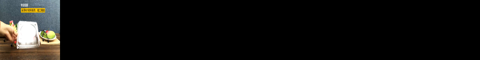

**00:13.50 - 00:24.70:**		The container is then shown being sealed.

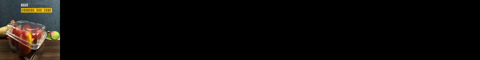

**00:25.40 - 00:29.60:**		The container is shown again, this time with the lid open.

IndexError: list index out of range

In [17]:
data = parse_json(response)

for item in data:
    start_time = item["start_time"]
    end_time = item["end_time"]
    description = item["description"]

    display(Markdown(f"**{start_time} - {end_time}:**\t\t" + description))

    start_time = time_to_seconds(start_time)
    end_time = time_to_seconds(end_time)
    current_frames = []
    for frame, timestamp in zip(frames, timestamps):
        if timestamp[0] > start_time and timestamp[1] < end_time:
            current_frames.append(frame)

    current_frames = np.array(current_frames)
    current_image_grid = create_image_grid(current_frames, num_columns=8)

    display(current_image_grid.resize((480, (int(len(current_frames) / 8) + 1) * 60)))


In [ ]:
## Use API for inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'

video_url = "http://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/cookbook/video_structured_caption_480p.mov"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with ‘mm:ss.ff’ format for time depiction."

response = inference_with_api(video_url, prompt)
display(Markdown(response))

ChatCompletion(id='chatcmpl-99fe141e-1f17-9a83-a3f3-f1121db9183a', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n[\n    {\n        "start_time": "00:25.00",\n        "end_time": "00:46.00",\n        "description": "cut the fat off a piece of brisket."\n    },\n    {\n        "start_time": "00:47.00",\n        "end_time": "01:30.00",\n        "description": "season the meat with salt and pepper."\n    },\n    {\n        "start_time": "01:31.00",\n        "end_time": "01:38.00",\n        "description": "sear the meat on a grill."\n    },\n    {\n        "start_time": "01:49.00",\n        "end_time": "02:04.00",\n        "description": "add onions carrots and celery to a pot."\n    },\n    {\n        "start_time": "02:05.00",\n        "end_time": "02:10.00",\n        "description": "stir the vegetables in the pot."\n    },\n    {\n        "start_time": "02:11.00",\n        "end_time": "02:20.00",\n        "description": "plac

```json
[
    {
        "start_time": "00:25.00",
        "end_time": "00:46.00",
        "description": "cut the fat off a piece of brisket."
    },
    {
        "start_time": "00:47.00",
        "end_time": "01:30.00",
        "description": "season the meat with salt and pepper."
    },
    {
        "start_time": "01:31.00",
        "end_time": "01:38.00",
        "description": "sear the meat on a grill."
    },
    {
        "start_time": "01:49.00",
        "end_time": "02:04.00",
        "description": "add onions carrots and celery to a pot."
    },
    {
        "start_time": "02:05.00",
        "end_time": "02:10.00",
        "description": "stir the vegetables in the pot."
    },
    {
        "start_time": "02:11.00",
        "end_time": "02:20.00",
        "description": "place the meat on top of the vegetables."
    },
    {
        "start_time": "02:21.00",
        "end_time": "02:30.00",
        "description": "pour beef stock into the pot."
    },
    {
        "start_time": "02:31.00",
        "end_time": "02:40.00",
        "description": "cover the pot with coals."
    }
]
```